In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD
import time
from sklearn.metrics import accuracy_score, mean_squared_error

/root/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#Hyperparameters

# the amount of previous days to train on
window_size = 40 

# Name of stock. Choose between AAPL, AMZN, FB, GOOG, MSFT
stock_name = 'GOOG' 

# Train percentage. The test data will be treated as future. Its prices will not be used.
train_test_split_percentage = 0.8

In [3]:
lstm_input = pd.read_csv("./Data/" + stock_name + "/lstm_input.csv")
lstm_input.head(10)

In [5]:
train_set_all = lstm_input.iloc[:int(len(lstm_input)*train_test_split_percentage)]
test_set_all = lstm_input.iloc[int(len(lstm_input)*train_test_split_percentage):]

In [6]:
train_set = train_set_all.drop(["date","open","high","low","volume"],axis=1)
test_set = test_set_all.drop(["date","open","high","low","volume"],axis=1)
train_set.head(10)

,close,y,sentiment
0,749.38,18.38,0.477296
1,749.16,-3.89,0.055972
2,753.46,3.61,0.022010
3,756.50,-3.45,0.014165
4,754.50,0.35,0.018087
5,761.78,2.73,0.017219
6,756.99,-8.21,0.744242
7,762.50,6.78,0.022541
8,768.05,5.30,0.019752
9,767.65,-3.06,0.356906


In [7]:
norm = MinMaxScaler(feature_range = (0, 1))
norm.fit(train_set)
train_set_norm = norm.transform(train_set)
test_set_norm = norm.transform(test_set)

In [8]:
train_set_array = np.array(train_set_norm)
train_set_array

array([[0.34893723, 0.82751389, 0.48368622],
       [0.34863299, 0.59400231, 0.05022026],
       [0.35457952, 0.67264339, 0.01527899],
       ...,
       [0.49742086, 0.69109783, 0.48368622],
       [0.48787875, 0.56705463, 0.48368622],
       [0.4868139 , 0.63625878, 0.9004032 ]])

In [9]:
trainData1 = []
trainData2 = []
trainData3 = []
trainLabels = []
for i in range(window_size, len(train_set_array)):
    trainData1.append(train_set_array[i-window_size:i, 0])
    trainData2.append(train_set_array[i-window_size:i, 1])
    trainData3.append(train_set_array[i-window_size:i, 2])
    trainLabels.append(train_set_array[i, 0])

trainData1,trainData2,trainData3, trainLabels = np.array(trainData1),np.array(trainData2),np.array(trainData3), np.array(trainLabels)
trainData = np.dstack((trainData1,trainData2,trainData3))
trainData.shape, trainLabels.shape

((1077, 40, 3), (1077,))

## Model Initialization

In [10]:
def create_model(neurons=80, optimizer='Adam', learn_rate=0.1, momentum=0, init_mode='uniform', activation='sigmoid', dropout=0.4):
    regressor = Sequential()
    regressor.add(LSTM(units = neurons, return_sequences = True, input_shape = (trainData.shape[1], 3)))
    regressor.add(Dropout(dropout))
    regressor.add(LSTM(units = neurons, return_sequences = True))
    regressor.add(Dropout(dropout))
    regressor.add(LSTM(units = neurons, return_sequences = True))
    regressor.add(Dropout(dropout))
    regressor.add(LSTM(units = neurons))
    regressor.add(Dropout(dropout))
    regressor.add(Dense(units = 1, kernel_initializer=init_mode, activation=activation))
    if optimizer == 'SGD':
        optimizer = SGD(lr=learn_rate, momentum=momentum)
    # 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam'
    # Put initialization of other optimizers here or use as it is. It doesn't matter.
    regressor.compile(optimizer = optimizer, loss = 'mean_squared_error')
    return regressor

## Model Checkpointing

In [11]:
filepath="./Data/" + stock_name + "/weights" + str(window_size) + "pnt.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [12]:
regressor = create_model()
regressor

In [13]:
for i in range(1):
    # In case the model diverges, re initialising the model with best weights so far.
    regressor.load_weights(filepath)
    
    #Fitting the model
    regressor.fit(trainData, trainLabels, validation_split=0.33, epochs=20, shuffle=True, batch_size=50, callbacks=callbacks_list, verbose=1)

Train on 721 samples, validate on 356 samples
Epoch 1/20
721/721 [==============================] - 7s 10ms/step - loss: 0.0014 - val_loss: 4.5386e-04

Epoch 00001: val_loss improved from inf to 0.00045, saving model to ./Data/GOOG/weights40pnt.best.hdf5
Epoch 2/20
721/721 [==============================] - 6s 8ms/step - loss: 0.0014 - val_loss: 5.8347e-04

Epoch 00002: val_loss did not improve
Epoch 3/20
721/721 [==============================] - 6s 8ms/step - loss: 0.0014 - val_loss: 6.2675e-04

Epoch 00003: val_loss did not improve
Epoch 4/20
721/721 [==============================] - 6s 8ms/step - loss: 0.0011 - val_loss: 3.8347e-04

Epoch 00004: val_loss improved from 0.00045 to 0.00038, saving model to ./Data/GOOG/weights40pnt.best.hdf5
Epoch 5/20
721/721 [==============================] - 6s 8ms/step - loss: 0.0012 - val_loss: 4.5506e-04

Epoch 00005: val_loss did not improve
Epoch 6/20
721/721 [==============================] - 6s 8ms/step - loss: 0.0014 - val_loss: 4.8225e-04


##  Loading best weights from Model Checkpointing

In [14]:
model  = create_model()
filepath="./Data/" + stock_name + "/weights" + str(window_size) + "pnt.best.hdf5"
model.load_weights(filepath)

##  Predicting after loading weights

In [15]:
fullData = pd.concat((train_set, test_set), axis = 0)
inputs = fullData[window_size:].values
inputs = norm.transform(inputs)
testData1 = []
testData2 = []
testData3 = []
testLabels = []
   
for i in range(window_size, len(inputs)-1):
    testData1.append(inputs[i-window_size:i, 0])
    testData2.append(inputs[i-window_size:i, 1])
    testData3.append(inputs[i-window_size:i, 2])
    testLabels.append(inputs[i, 0])

testData1,testData2,testData3, testLabels = np.array(testData1), np.array(testData2), np.array(testData3), np.array(testLabels)
print(testData1.shape)
print(testData2.shape)
print(testData3.shape)
testData = np.dstack((testData1,testData2,testData3))
predicted_stock_price = model.predict(testData)
print(predicted_stock_price[:20].T[0])

(1316, 40)
(1316, 40)
(1316, 40)
[0.3078973  0.3037904  0.3033315  0.31248778 0.3277496  0.33961597
 0.35435122 0.36478043 0.37165946 0.38296017 0.37907642 0.37099904
 0.37438166 0.38247073 0.39154243 0.39311194 0.3934364  0.3934515
 0.39859334 0.40651897]


## Final testing from grid_result.best_params_ dict.

In [16]:
test_set_true = inputs.T[0][window_size + 1:]
test_set_true[:20]

array([0.33803986, 0.3550912 , 0.35486994, 0.35080417, 0.35488377,
       0.3550912 , 0.35766343, 0.38519727, 0.36226853, 0.37156173,
       0.37768804, 0.38291546, 0.39870836, 0.39462876, 0.39225014,
       0.39523724, 0.4020965 , 0.40910788, 0.42841338, 0.40851323])

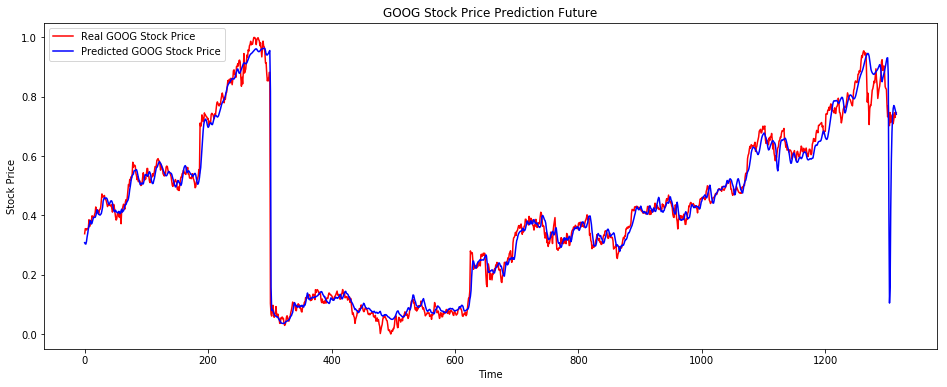

In [21]:
# Visualising the results
width = 16
height = 6
plt.figure(figsize=(width, height))


# Just keeping the test Data
offset = 0#train_test_split_percentage
test_set_true_graph = test_set_true[int(len(test_set_true)*offset):]
predicted_stock_price_graph = predicted_stock_price[int(len(predicted_stock_price)*offset):]


plt.plot(test_set_true_graph, color = 'red', label = 'Real ' + stock_name + ' Stock Price')
plt.plot(predicted_stock_price_graph, color = 'blue', label = 'Predicted ' + stock_name + ' Stock Price')
plt.title('' + stock_name + ' Stock Price Prediction Future')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [18]:
pred_up_down = []
true_up_down = []
for i in range(len(test_set_true)-1):
    pred_up_down.append(predicted_stock_price[i+1] - predicted_stock_price[i])
    true_up_down.append(test_set_true[i+1] - test_set_true[i])
    
msa = mean_squared_error(predicted_stock_price, test_set_true)
pred_up_down = np.array(pred_up_down) > 0
true_up_down = np.array(true_up_down) > 0

acc = accuracy_score(pred_up_down, true_up_down)

In [19]:
print(stock_name, '\nMean Squared Error   :', msa, '\nDirectional Accuracy :', acc, sep=' ')

GOOG 
Mean Squared Error   : 0.002049097058838995 
Directional Accuracy : 0.4768060836501901


In [20]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3913840005932368269
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 169869312
locality {
  bus_id: 1
}
incarnation: 7723269891492902211
physical_device_desc: "device: 0, name: GeForce GT 730, pci bus id: 0000:02:00.0"
]
